# 作業 : (Kaggle)鐵達尼生存預測
***
https://www.kaggle.com/c/titanic

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")

data_path = 'data_part02/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 梯度提升樹擬合後, 將結果依照重要性由高到低排序 (note : D27作業中'Ticket'是第一名特徵, 'Age'是數值特徵中排名最高者)
estimator = GradientBoostingClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.444030
Pclass      0.111875
Ticket      0.097379
Fare        0.087329
Name        0.083464
Age         0.073144
Cabin       0.071305
Embarked    0.012220
Parch       0.011547
SibSp       0.007706
dtype: float64

## 先用梯度提升機對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

In [4]:
# 原始特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8215972695810002

In [5]:
# 高重要性特徵 + 梯度提升樹 
high_feature = list(feats[:5].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8125895324717789

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

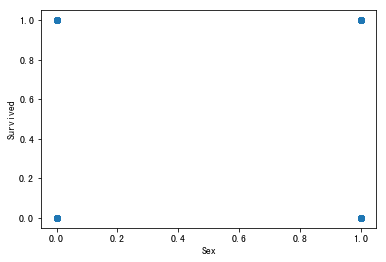

In [6]:
# 觀察重要特徵與目標的分布
# 第一名 : Sex              
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.regplot(x=df['Sex'], y=train_Y, fit_reg = False)
plt.show()

In [7]:
print(pd.crosstab(df.Sex, train_Y))
print(pd.crosstab(df.Sex, train_Y).apply(lambda r: r/r.sum(), axis = 1))

Survived    0    1
Sex               
0.0        81  233
1.0       468  109
Survived         0         1
Sex                         
0.0       0.257962  0.742038
1.0       0.811092  0.188908


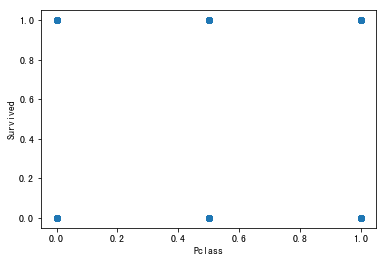

In [8]:
# 第二名 : Pclass      
sns.regplot(x=df['Pclass'], y=train_Y, fit_reg=False)
plt.show()

In [9]:
print(pd.crosstab(df.Pclass, train_Y))
print(pd.crosstab(df.Pclass, train_Y).apply(lambda r: r/r.sum(), axis = 1))

Survived    0    1
Pclass            
0.0        80  136
0.5        97   87
1.0       372  119
Survived         0         1
Pclass                      
0.0       0.370370  0.629630
0.5       0.527174  0.472826
1.0       0.757637  0.242363


In [10]:
pd.crosstab(df.Sex, df.Pclass, margins = True)

Pclass,0.0,0.5,1.0,All
Sex,,,,
0.0,94,76,144,314
1.0,122,108,347,577
All,216,184,491,891


In [11]:
df_all = pd.merge(df, pd.DataFrame(train_Y), how = 'left', on = df.index)
df_all.head()

,key_0,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000,0
1,1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333,1
2,2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000,1
3,3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000,1
4,4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000,0


In [12]:
pd.pivot_table(df_all, index = ['Sex'], columns = ['Pclass'], values = ['Survived'], aggfunc = np.mean, margins = True)

Survived                              
Pclass       0.0       0.5       1.0       All
Sex                                           
0.0     0.968085  0.921053  0.500000  0.742038
1.0     0.368852  0.157407  0.135447  0.188908
All     0.629630  0.472826  0.242363  0.383838

In [13]:
def newone(row):
    if (row['Sex'] == 0) & (row['Pclass'] <= 0.5):
        return '1'
    if (row['Sex'] == 0) & (row['Pclass'] == 1):
        return '2'
    if (row['Sex'] == 1) & (row['Pclass'] == 0):
        return '3'
    if (row['Sex'] == 1) & (row['Pclass'] >= 0.5):
        return '4'
    return '0'
        
df['SexPclass'] = df.apply(lambda row: newone(row), axis = 1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexPclass
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000,4
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333,1
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000,2
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000,1
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000,4


In [14]:
# 製作新特徵看效果
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8304979418658217